# **Week 6**

## Imports

In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint

np.random.seed(42)
# to make this notebook's output standard across all runs

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.metrics import log_loss #also known as cross entropy loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.metrics import precision_recall_curve

#scipy
from scipy.stats import loguniform

#for plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


#global settings 
mpl.rc('axes',labelsize=14) 
mpl.rc('xtick',labelsize=12) 
mpl.rc('ytick',labelsize=12) 
mpl.rc('figure',figsize=(8,6))


In [ ]:
#Ignore all warnings (convergence..) by sklearn 
def warn(*args,**kwargs): 
  pass
import warnings  
warnings.warn = warn


# MNIST Digit Classification using SGDClassifier
In this section we solve the same problem of recognizing Handwritten digits using Logistic regression model.

## Handwritten Digit Classification
* We are going to use LogisticRegression (Despite it's name) to classify (recognize) given digit image. Again, we first apply the model for binary classification and then extend it to multiclass classification.

* Suppose we want to recognize whether the given image is of digit zero or not (digits other than zero). Then the problem could be case as binary classification problem.
 * The first step is to create a dataset that contains collection of digit images (also called examples, samples) written by humans. Then each image should be labelled properly. Daunting taks! 
 * Fortunately, we have a standard benchmark dataset called **MNIST**. Well, why not make use of it? Let us import the dataset first...

In [ ]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784' , version = 1 , return_X_y = True)

In [ ]:
X_pd.max()

pixel1       0.0
pixel2       0.0
pixel3       0.0
pixel4       0.0
pixel5       0.0
            ... 
pixel780    62.0
pixel781     0.0
pixel782     0.0
pixel783     0.0
pixel784     0.0
Length: 784, dtype: float64

The data matrix $X$ and the respective label vector $y$ need to be converted to numpy array by calling a `to_numpy` method.


In [ ]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()


In [ ]:
X_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB


In [ ]:
y_pd

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [ ]:
y_pd.unique()

['5', '0', '4', '1', '9', '2', '3', '6', '7', '8']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

##Pre-Processing 
* Unlike perceptron, where scaling the range is optional(but recommended), sigmoid requires range between 0 to 1.
* Contemplate the consequence if we don't apply the scaling operation on the input datapoints.
* Note: **Do not** apply mean centering as it removes zeros from the data, however zeros should be zeros in the dataset.
* Since we are using only one preprocessing step, using `pipeline` may not be required.

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
X.shape

(70000, 784)

## Data Splitting

In [ ]:
x_train, x_test, y_train, y_test = X[:60000],X[60000:], y[:60000:], y[60000:]
# random shuffle is not required so we are not using train_test_split

##Binary Classification : 0-Detector 
* Let us start with a simple classification problem, that is, binary classification.
* Since the original label vector contains 10 classes, we need to modify the number of classes to 2. Therefore, the label '0' will be changed to '1' and all other labels(1-9) will be changed to '0' 
* **(Note: for perceptron we set the negative labels to -1)**

In [ ]:
y_train

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [ ]:
#intialize the label vector containing all zeros and replace with 1 where '0' occurs
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

# return indices where '0' occurs
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx__0 = np.where(y_test == '0')
y_test_0[indx__0] = 1


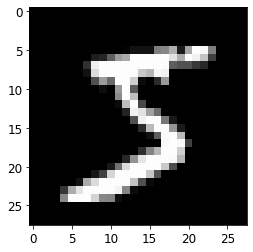

In [ ]:
plt.imshow(X[0].reshape(28,28), cmap = 'gray')


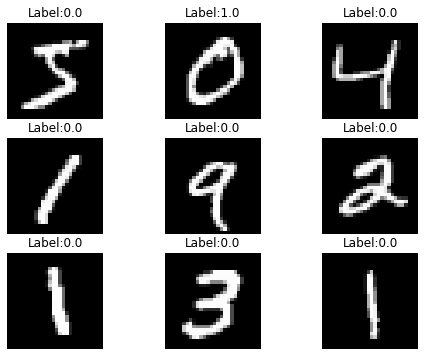

In [ ]:
import matplotlib.pyplot as plt
num_images = 9 # Choose a square number 
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor, ncols=factor,figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+ i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

##Baseline Models
Let us quickly construct a baseline model with the following rule 
1. Count number of samples per class.
2. The model **always output** the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.

In [ ]:
num_zeros = np.where(y_train_0 == 0 ,1,0).sum()
num_ones = np.where(y_train_0 == 1 ,1,0).sum()
num_zeros, num_ones

In [ ]:
base_clf = DummyClassifier(strategy = 'most_frequent')
base_clf.fit(x_train , y_train_0)
base_clf.score(x_train, y_train_0)

Now the reason is obvious. The model would have predicted 54077 sample correctly just by outputing 0 for all the input samples. Therefore the accuracy will be $\frac{54077}{60000}=90.12 \%$

##LogisticRegression model 
Before using LogisticRegression for Binary classification problem, it will be helpful to recall the important concepts (equations) covered in the technique course.

##Recap

Let us quickly recap various  components in the general settings:
  1. **Training data**: (features,label) or $(\mathbf X,y)$, where label $y$ is a **discrete** number from a finite set. **Features** in this case are pixel values of an image.
  2. Model: 
$$ z = w_0x_0 + w_1x_1+ \ldots + w_mx_m$$
$$ = \mathbf {w}^T \mathbf x$$ and passing it through the sigmoid non-linear function (or Logistic function)
$$ \sigma(z)=\frac{1}{1+e^{-z}}$$
3. Loss function: 
\begin{equation} J(\mathbf w) = -\frac{1}{n} \mathbf \sum [y^{(i)} \log(h_w(\mathbf x^{(i)}))+(1-y^{(i)})(1-\log(h_w(\mathbf x^{(i)})))] \end{equation}

4. **Optimization**
Gradient Descent 

* Let's look into the parameters of the `SGDClassifier()` estimator:
`class sklearn.linear_model.SGDClassifier(loss='hinge', *,penalty='l2', alpha=0.0001, l1_ratio = 0.15, fit_intercept =True, max_iter =1000, tol=0.001, shuffle=True, verbose =0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate = 'optimal', eta0=0.0, power_t = 0.5, early_stopping = False, validation_fraction =0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)`.

* Setting the loss parameter to `loss=log` makes it a logistic regression classifier. We may refer to documentation for more details on the `SGDClassifier` class.
* Create an instant of binary classifier(bin_sgd_clf) and call the `fit` method to train the model.
*Let us use fit method of `SGDClassifier()` to plot the iteration vs loss curve(Of course, we could use `partial_fit()` method as well) 
* Therefore, to capture the loss for each iterations during training we set the parameters `warm_start =True` and `max_iter=1`



## Training without regularization

* Set `eta0=0.01,learning_rate='constant' ` and `alpha=0`.

In [ ]:
bin_sgd_clf = SGDClassifier(loss = 'log',
                          penalty = 'l2',
                          alpha  = 0, 
                          warm_start = True, 
                          max_iter = 1,
                          eta0 = 0.01 ,
                          learning_rate  = 'constant',
                          random_state = 1729)
iterations = 100
Loss = []
for i in range(iterations):
  bin_sgd_clf.fit(x_train , y_train_0)
  y_pred = bin_sgd_clf.predict_proba(x_train)
  Loss.append(log_loss(y_train_0 ,y_pred))


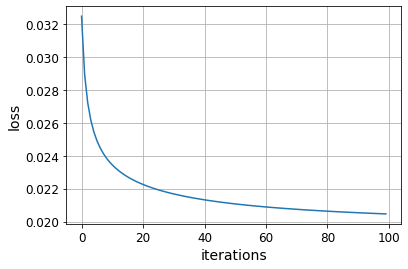

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid('True')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [ ]:
#Lets check the accuracy of our model
print('Training Accuracy : {0}'.format(bin_sgd_clf.score(x_train, y_train_0)))
print('Testing Accuracy : {0}'.format(bin_sgd_clf.score(x_test, y_test_0)))

Training Accuracy : 0.99395
Testing Accuracy : 0.9919


* We know that accuracy alone is not a good metric for binary classification.
* Let's compute Precision,recall and f1-score for the model.


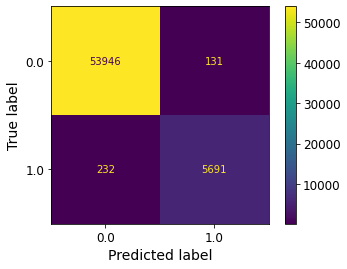

In [ ]:
y_hat_train_0 = bin_sgd_clf.predict(x_train)

display_confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_train_0 , y_hat_train_0 ,values_format = '.5g')

In [ ]:
print(classification_report(y_train_0 , y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



Do Cross validation to check for the generalization ability of the model.

In [ ]:
estimator = SGDClassifier(loss = 'log',
                         penalty = 'l1',
                         max_iter = 100,
                         warm_start = False,
                          alpha = 0,
                          learning_rate = 'constant',
                          eta0 = 0.01,
                          random_state = 1729)

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
sgd_bin_cv = cross_validate(estimator ,
                            x_train,
                            y_train_0,
                            cv = 5,
                            scoring = ['precision', 'recall', 'f1'],
                            return_train_score = True,
                            return_estimator = True)

In [ ]:
sgd_bin_cv

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, penalty='l1', random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, penalty='l1', random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, penalty='l1', random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, penalty='l1', random_state=1729),
  SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
                max_iter=100, penalty='l1', random_state=1729)],
 'fit_time': array([2.57122231, 3.9116838 , 2.72154856, 2.81305099, 4.89204979]),
 'score_time': array([0.04105568, 0.04455614, 0.0407424 , 0.0418849 , 0.09471273]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429,

* From the above result, we can see that logistic regression is better than the perceptron.! 

* However, it is good to check the weight values of all the features and decide whether regularization could be of any help.


In [ ]:
weights = bin_sgd_clf.coef_

In [ ]:
len(weights[0])

784

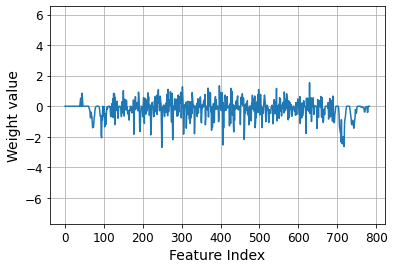

In [ ]:
plt.figure() 
plt.plot(np.arange(0,784),weights[0,:])
plt.ylim(np.min(weights[0])-5,np.max(weights[0])+5)
plt.grid(True)
plt.xlabel('Feature Index')
plt.ylabel('Weight value')
plt.show()


* It is interesting to observe how many weight values are exactly zero.
* Those features contribute nothing in the classification.
* From the above plot, it is obvious that regualarization is not required, since weight values are not too high(low variance
)

In [ ]:
print(len(weights[0]) - np.count_nonzero(weights[0]))

67


There are 67 zero weights

## Training with Regularization

In [ ]:
bin_sgd_clf_l2 = SGDClassifier(loss = 'log',
                               penalty = 'l2',
                               alpha = 0.001,
                               eta0  = 0.01,
                               warm_start = True,
                              
                               learning_rate = 'constant',
                               max_iter = 1,
                               random_state = 1729)

iterations = 100
Loss_= []
for i in range(iterations):
  bin_sgd_clf_l2.fit(x_train , y_train_0)
  y_pred_r = bin_sgd_clf_l2.predict_proba(x_train)
  Loss_.append(log_loss(y_train_0,y_pred_r))

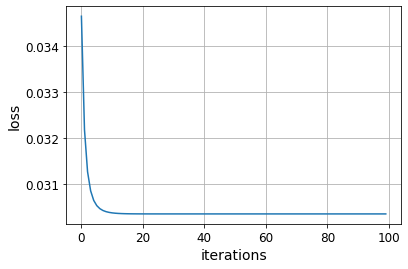

In [ ]:
plt.figure()
plt.plot(np.arange(iterations),Loss_)
plt.grid(True)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [ ]:
#calculation of weights and bias
weights = bin_sgd_clf_l2.coef_ 
bias = bin_sgd_clf_l2.intercept_

print(weights.shape, bias)

(1, 784) [-4.43002876]


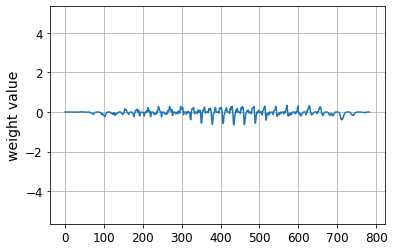

In [ ]:
plt.plot(np.arange(784), weights[0])
plt.ylim(np.min(weights)-5 ,np.max(weights) + 5)
plt.ylabel('weight value')
plt.grid(True)

In [ ]:
print(len(weights[0]) - np.count_nonzero(weights[0]))
# number of weights with zero value

67


In [ ]:
y_hat_train_R_0 = bin_sgd_clf_l2.predict(x_train)

In [ ]:
print(classification_report(y_hat_train_R_0, y_train_0))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     54404
         1.0       0.93      0.98      0.95      5596

    accuracy                           0.99     60000
   macro avg       0.96      0.99      0.97     60000
weighted avg       0.99      0.99      0.99     60000



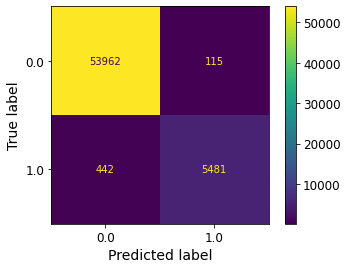

In [ ]:
display_confusion_matrix_r = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_R_0,values_format= '.5g')

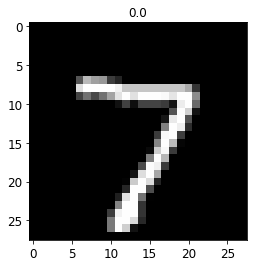

In [ ]:
indx = 0
plt.imshow(x_test[indx].reshape(28,28),cmap = 'gray')
plt.title(str(y_hat_train_R_0[indx]))
plt.show()

Let's plot a few images and their respective **predictions** with SGDClassifier without regularization.

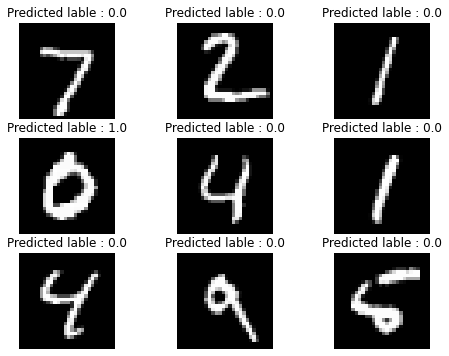

In [ ]:
y_hat_test_0 = bin_sgd_clf.predict(x_test)
num_images = 9 
factor  = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor , ncols = factor, figsize = (8,6))
idx_offset  = 0 
for i in range(factor):
  index = idx_offset = i*factor
  for j in range(factor):
    ax[i,j].imshow(x_test[index + j].reshape(28,28) , cmap = 'gray')
    ax[i,j].set_title('Predicted lable : {0}'.format(y_hat_test_0[index +j]))
    ax[i,j].set_axis_off()


In [ ]:
indx_0 = np.where(y_test_0 == 1)
type(indx_0 
     )

tuple

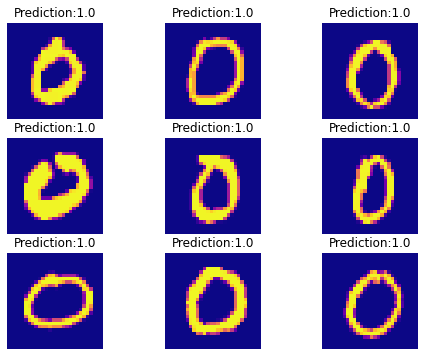

In [ ]:
zeroImgs= x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9 # choose a square number 
factor = np.int(np.sqrt(num_images)) 
fig,ax = plt.subplots(nrows=factor, ncols = factor, figsize=(8,6))
idx_offset  = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='plasma')# we should not use x_train_with_
    ax[i,j].set_title("Prediction:{0}".format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

## Hyper-parameter tuning
* We have to use cross-validate folds and mesure the same metrics across these folds for different values of hyper-parameters.
* Logistic regression uses **sgd** solver and hence the learning rate and regularization rate are two important hyper-parameters.
* For the moment, we skip penalizing the parameters of the model and just search for a better learning rate using `RandomizedSearchCV() and draw the value from the uniform distribution.

In [ ]:
lr_grid = loguniform(1e-2 , 1e-1)

* Note that, `lr_grid` is an object that contains a method called `rvs()` which can be used to get the samples of given size.
* Therefore, we pass this `lr_grid` object to `RandomizedSearchCV()`. Internally, it makes use of this `rvs()` method for sampling.


In [ ]:
print(lr_grid.rvs(3 , random_state = 42))

[0.02368864 0.0892718  0.05395031]


In [ ]:
estimator = SGDClassifier(loss = 'log',
                          penalty = 'l1',
                          alpha  = 0,
                          max_iter =1,
                          warm_start = True,
                          eta0 = 0.01,
                          learning_rate = 'constant',
                          random_state = 1729)



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
scores = RandomizedSearchCV(estimator, 
                            param_distributions= {'eta0' : lr_grid},
                            cv = 5,
                            scoring = ['precision', 'recall', 'f1'],
                            n_iter = 5,
                            refit = 'f1')


In [ ]:
scores.fit(x_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, penalty='l1',
                                           random_state=1729, warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f12ee32b450>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [ ]:
pprint(scores.cv_results_)

{'mean_fit_time': array([0.66343837, 0.47449703, 0.47311883, 0.47474937, 0.47542896]),
 'mean_score_time': array([0.05468798, 0.04146013, 0.04227982, 0.04192629, 0.0628427 ]),
 'mean_test_f1': array([0.95383975, 0.94148246, 0.94869555, 0.95090017, 0.95474878]),
 'mean_test_precision': array([0.96136672, 0.93597638, 0.94998271, 0.9540212 , 0.96640269]),
 'mean_test_recall': array([0.94682062, 0.94851138, 0.94834146, 0.94850966, 0.94361173]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                   0.05395030966670228, 0.039687933304443715,
                   0.01432249371823025],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.02368863950364078},
            {'eta0': 0.08927180304353625},
            {'eta0': 0.05395030966670228},
            {'eta0': 0.039687933304443715},
            {'eta0': 0.01432249371823025}],
 'rank_test_f1': array([2, 5, 4, 3, 1], dtype=int32),


In [ ]:
best_bin_clf = scores.best_estimator_

In [ ]:
scores.best_params_

{'eta0': 0.01432249371823025}

In [ ]:
y_hat_train_best_0 = best_bin_clf.predict(x_train)

In [ ]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



##Classification Report
**Precision/Recall Tradeoff** 


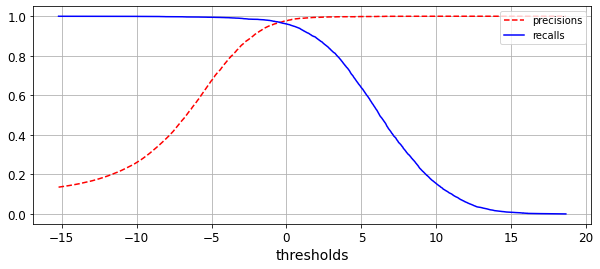

In [ ]:
y_scores = bin_sgd_clf.decision_function(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0,y_scores)
plt.figure(figsize=(10,4)) 
plt.plot(thresholds,precisions[:-1],'r--',label='precisions')
plt.plot(thresholds,recalls[:-1],'b-',label='recalls')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('thresholds')
plt.show()

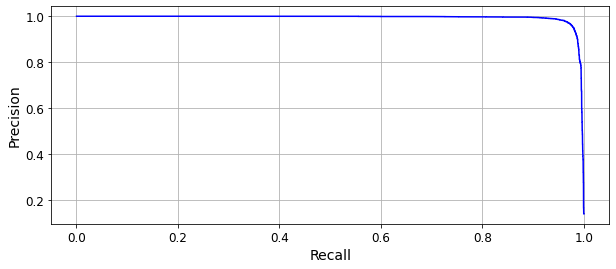

In [ ]:
#precision recall curve 
plt.figure(figsize=(10,4))
plt.plot(recalls[:-1],precisions[:-1], 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## The ROC Curve 


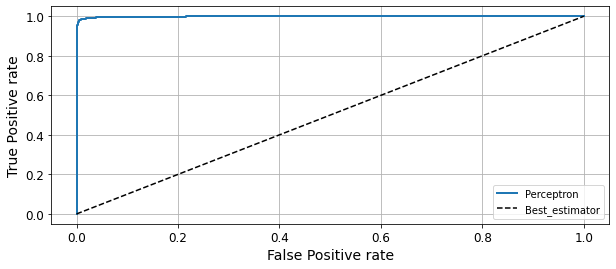

In [ ]:
fpr,tpr,thresholds = roc_curve(y_train_0,y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr,tpr,linewidth=2,label='Perceptron')
plt.plot([0,1],[0,1],'k--',label='Best_estimator')
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#roc auc curve 

auc=roc_auc_score(y_train_0,y_scores)
print('AUC: {0:.3f}'.format(auc))

AUC: 0.999


#  MNIST Digit Classification using Logistic Regression 


* In the previous setup, we used `SGDClassifier` to train 0-detector model in an iterative manner.
 * We can also train such a classifier by solving a set of equations obtained by setting the derivative of loss w.r.t. weights to 0.
 * These are not linear equations and therefore we need a different set of solvers.

* Sklearn uses solvers like `liblinear`, `newton-cg`, `sag` `saga` and `lbfgs` to find the optimal weights.
* Regularization is applied by default.
* Parameters: 
  `LogisticRegression(penalty='l2',*,dual=False, tol=0.0001, c=1.0, fit_intercept = True, intercept_scaling=1, class_weight=None, solver='lbfgs',max_iter=100,multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio =None)` 
* Note some of the important default parameters:
  * Regularization: `penalty='l2'`
  * Regularization rate: `C=1`
  * Solver: `solver = 'lbfgs'`
* Let's implement LogisticRegression(), **without regularization** by setting the parameter $ C= \infty $. Therefore, we may expect performance close to `SGDClassifier` without regularization.

## Training without regularization 
* **STEP 1:** Instantiate a pipeline object with two stages:
 * The first stage contains `MinMaxScaler` for scaling the input.
 * The second state contains a `LogisticRegression` classifier with the regularization rate $C = \infty $
* **STEP 2:** Train the pipeline with feature matrix `x_train` and label vector `y_train_0`.


In [ ]:
from sklearn.pipeline import Pipeline ,make_pipeline

In [ ]:
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729,
                                                              solver='lbfgs',
                                                              C=np.infty))
pipe_logit.fit(x_train, y_train_0)


NameError: ignored

In [ ]:
pipe_logit.score(x_train, y_train_0)

By executing this cell, we trained our `LogisticRegression` classifier, which can be used for making predictions on the new inputs.

## Hyperparameter search 




##**With `GridSearchCV`**


In the previous cell we trained `LogisticRegression` Classifier with default parameterization.

Now we will demonstrate how to search for the best parameter value for regularization rate C, as an illustration, using GridSearchCV.

   Note that you can also use `RandomizedSearchCV` for this purpose.

In order to use `GridSearchCV`, we first define a set of values that we want to try out for c. The best value of c will be found from this set.

We define the `pipeline` object exactly like how we defined in the previous cell while using `LogisticRegression` classifier with default parameters and no regularization.

The additional step here is to instantiate a `GridSearchCV` object with a `pipeline` estimator, parameter grid specification and f1 as a scoring function.

  Note that you can use other scoring functions like `precision`, `recall`, however the value of C is found such that the given scoring function is optimized.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

grid_Cs = [0,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]

scaler = MinMaxScaler()
logreg = LogisticRegression(C = 1.0 , random_state = 1729)

log_pipe = Pipeline([('scaler',scaler),
                     ('logreg', logreg)])

log_gridcv = GridSearchCV(log_pipe,
                          param_grid = {'logreg__C':grid_Cs},
                          scoring = 'f1')
log_gridcv.fit(x_train , y_train_0)


GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logreg',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logreg__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                       100.0]},
             scoring='f1')

The `GridSearchCV` finds the best value of c and refits the estimator by default on the entire training set. This gives us the logistic regression classifier with best value of C.

We can check the value of the best parameter by accessing the `best_params_` member variable of the `GridSearchCV` object.


In [ ]:
log_gridcv.best_params_

{'logreg__C': 0.1}

and the best score can be found in `best_score_` member variable and can be obtained as follows:


In [ ]:
log_gridcv.best_score_

0.9579654953103655

The best estimator can be accessed with `best_estimator_` member variable.

In [ ]:
log_gridcv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logreg', LogisticRegression(C=0.1, random_state=1729))])

## With `LogisticRegressionCV` 

Instead of using `GridSearchCV` for finding the best value for parameter c, we can use `LogisticRegressionCV` for performing the same job. 
  * **STEP 1**: Here we make use of `LogisticRegressionCV` estimator with number of cross validation folds `cv=5` and scoring scheme `scoring='f1'` in the `pipeline` object.

  * **STEP 2**: In the second step, we train the pipeline object as before.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
log_cv = LogisticRegressionCV( cv = 5 ,scoring = 'f1' , random_state= 1729)
log_cv_pipe = make_pipeline(MinMaxScaler(), log_cv)
log_cv_pipe.fit(x_train , y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

By default, `LogisticRegressionCV` refits the model on the entire training set with the best parameter values obtained via cross validation.

##Performance evaluation.

Precision, recall, f1-score 

Let's evaluate performance of these three different logistic regression classifiers for detecting digit 0 from the image.

 * Logistic regression without regularization 
 * Best logistic regression classifier found through `GridSearchCV`.
 * Best classifier found through `LogisticRegressionCV`.
  Note that `GridSearchCV` and `LogisticRegressionCV` by default refit the classifier for the best hyperparameter values. 

Let's get prediction for test set with these three classifiers: 

In [ ]:
lr_y_hat_0 = pipe_logit.predict(x_test)
lr_gcv_y_hat_0 = log_gridcv.predict(x_test)
lr_lcv_y_hat_0 = log_cv_pipe.predict(x_test)

We will compare **Recall, Precision  F1 score** for the three classifiers

In [ ]:
precision_log = precision_score(y_test_0 , lr_y_hat_0)
recall_log = recall_score(y_test_0 , lr_y_hat_0)

precision_gridcv = precision_score(y_test_0, lr_gcv_y_hat_0)
recall_gridcv = recall_score(y_test_0, lr_gcv_y_hat_0)

precision_logcv = precision_score(y_test_0 , lr_lcv_y_hat_0)
recall_logcv = recall_score(y_test_0 , lr_lcv_y_hat_0)

In [ ]:
print('LogReg: Precision: {0} ,Recall: {1}'.format(precision_log,recall_log))
print('LogGridCv: Precision: {0} ,Recall: {1}'.format(precision_gridcv , recall_gridcv))
print('LogRegCV: Precision: {0} ,Recall: {1}'.format(precision_logcv, recall_logcv))

LogReg: Precision: 0.9515151515151515 ,Recall: 0.9612244897959183
LogGridCv: Precision: 0.9564336372847011 ,Recall: 0.963265306122449
LogRegCV: Precision: 0.9546370967741935 ,Recall: 0.9663265306122449


Note that all three classifiers have roughly the same performance as measured with precision and recall.
 * The `LogisticRegression` classifier obtained through `GridSearchCV` has the highest precision-marginally higher that the other two classifiers.
 * The `LogisticRegression` classifier obtained through `LogisticRegressionCV` has the highest recall - marginally higher than the other two classifiers.

Using PR-curve


In [ ]:
y_scores_lr = pipe_logit.decision_function(x_test)
precisions_lr, recalls_lr, thresholds_lr= precision_recall_curve(y_test_0, y_scores_lr)

y_scores_lr_gs = log_gridcv.decision_function(x_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs= precision_recall_curve(y_test_0, y_scores_lr_gs)

y_scores_lr_cv = log_cv_pipe.decision_function(x_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv= precision_recall_curve(y_test_0, y_scores_lr_cv)


We have all the quantities for plotting the PR curve. Let's plot PR curve for all three classifiers.

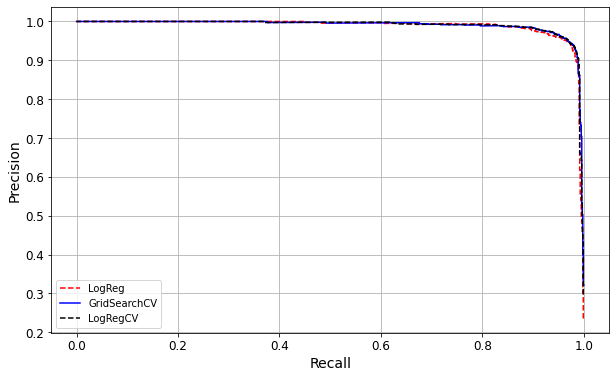

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(recalls_lr, precisions_lr, 'r--',label='LogReg')
plt.plot(recalls_lr_gs, precisions_lr_gs,'b-',label="GridSearchCV") 
plt.plot(recalls_lr_cv, precisions_lr_cv,'k--',label='LogRegCV')

plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend() 
plt.show()

lets calculater AUC for each model

In [ ]:
from sklearn.metrics import auc
auc_lr = auc(recalls_lr , precisions_lr)
auc_gcv = auc(recalls_lr_gs, precisions_lr_gs)
auc_lr_cv  = auc(recalls_lr_cv, precisions_lr_cv)

In [ ]:
print(f'Logistic AUC : {auc_lr}, log_gridcv AUC : {auc_gcv} , log_lr_cv = {auc_lr_cv}')

Logistic AUC : 0.988154157939231, log_gridcv AUC : 0.9896724785220581 , log_lr_cv = 0.989651942903504


Observe that the AUC for all three classifier is roughly the same with `LogisticRegression` classifier obtained through cross validation and grid search have slightly higher AUC under PR curve.



## Confusion Matrix 


### For test set with logistic regression classifier:

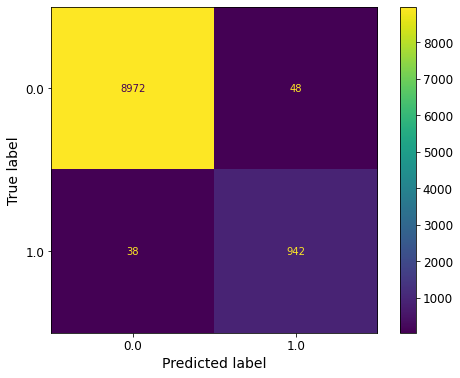

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,lr_y_hat_0, values_format='.5g')
plt.show()

### For test set with GridsearchCV 

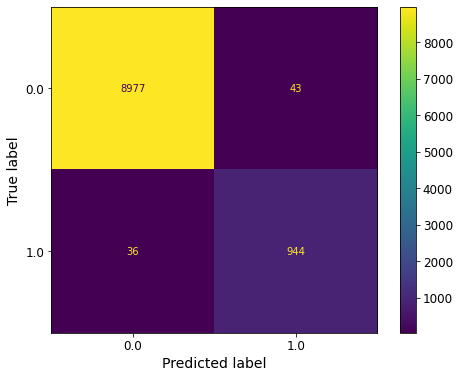

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gcv_y_hat_0, values_format = '.5g')

### For test set with LogisticRegressionCV

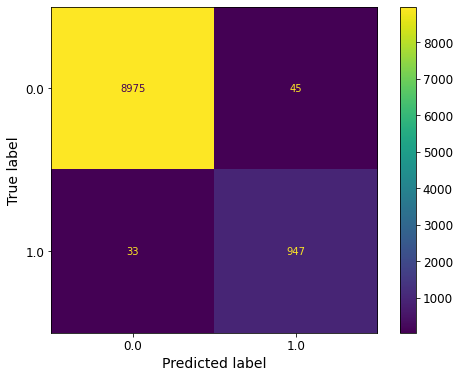

In [ ]:
cm_display =ConfusionMatrixDisplay.from_predictions(y_test_0,lr_lcv_y_hat_0 ,values_format = '.5g')

# MNIST Zero Detector using Ridge Classifier

* Ridge classifier cast the problem as least-square classification and finds the optimal weight using some matrix decomposition technique such as SVD.
* To train the ridge classifier, the labels should be $ y \in \{+1,-1\}$
* The classifier also by default implements L2 regularization. However, we first implement it without regularization by setting `alpha=0`

## Creating Labels

In [ ]:
#intialize all values to -1
y_train_0 = -1 * np.ones(len(y_train))
y_test_0 = -1 * np.ones(len(y_test))

#set values equal to 1 where label is zero

indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1

indx__0 = np.where(y_test == '0')
y_test_0[indx__0] = 1


* First take a look into the parameters of the class
  `RidgeClassifier(alpha=1.0,*,fit_intercept=True, normalize='deprecated',copy_X=True,max_iter=None, tol=0.001,class_weight=None, solver='auto', positive=False,random_state=None)` 

* Note the parameter `normalize` is deprecated. 

## Training RidgeClassifier without regualarization

In [ ]:
estimator  = RidgeClassifier(normalize = False , alpha = 0)
ridge_pipe = make_pipeline(MinMaxScaler() , estimator)
ridge_pipe.fit(x_train , y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

In [ ]:
# Performance
y_hat_test_0 = ridge_pipe.predict(x_test)
print(classification_report(y_test_0 , y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.87      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.93      0.95     10000
weighted avg       0.98      0.98      0.98     10000



## Cross Validation

In [ ]:
ridge_pipe_cv  = cross_validate(ridge_pipe, 
                                x_train,
                                y_train_0,
                                cv = 5,
                                scoring = ['precision', 'recall', 'f1'],
                                return_train_score = True,
                                return_estimator = True)

pprint(ridge_pipe_cv)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([14.25192952, 10.12674737, 10.19526696, 10.16861224, 15.07721686]),
 'score_time': array([0.15462255, 0.10768771, 0.10155201, 0.1314013 , 0.14506769]),
 'test_f1': array([0.90710859, 0.90917108, 0.92334802, 0.904     , 0.90892857]),
 'test_preci

In [ ]:
best_estimator_id = np.argmax(ridge_pipe_cv['train_f1'])
best_estimator_id

2

In [ ]:
best_estimator = ridge_pipe_cv['estimator'][best_estimator_id]

Lets evaluate the performance of best_estimator on the test set

In [ ]:
y_hat_test_cv_0 = best_estimator.predict(x_test)
print(classification_report(y_test_0 , y_hat_test_cv_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      9020
         1.0       0.95      0.90      0.93       980

    accuracy                           0.99     10000
   macro avg       0.97      0.95      0.96     10000
weighted avg       0.99      0.99      0.99     10000



# Further Exploration

Lets see what these classifiers learnt about the digit zero

<Figure size 288x288 with 0 Axes>

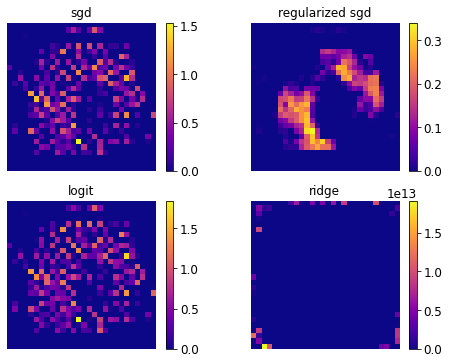

In [ ]:
models = (bin_sgd_clf,bin_sgd_clf_l2,pipe_logit,ridge_pipe)
titles =('sgd','regularized sgd','logit','ridge')
plt.figure(figsize=(4,4))
plt.subplots(2,2)
for i in range(0,4):
  if i<2:
    w = models[i].coef_
  else: 
    w = models[i][1].coef_ 
  w_matrix = w.reshape(28,28) 
  w_matrix[w_matrix < 0 ]=0 # just set the value less than zero to zero
  plt.subplot(2,2,i+1)
  plt.imshow(w_matrix,cmap='plasma') 
  plt.title(titles[i])
  plt.axis('off')
  plt.grid(False) 
  plt.colorbar()
  
plt.show()

# Multiclass Classifier on MNIST Dataset

## Multiclass classification using SGD

In [ ]:
estimator = SGDClassifier(loss = 'log',
                          penalty = 'l2',
                          max_iter = 1,
                          warm_start = True ,
                          eta0 = 0.01,
                          alpha = 0,
                          learning_rate = 'constant',
                          random_state = 1729)
pipe_sgd_ovr = make_pipeline(MinMaxScaler(),estimator)


In [ ]:
Loss = [] 
iterations = 100 
for i in range(iterations):
  pipe_sgd_ovr.fit(x_train,y_train) 
  y_pred = pipe_sgd_ovr.predict_proba(x_train) 
  Loss.append(log_loss(y_train,y_pred)) 

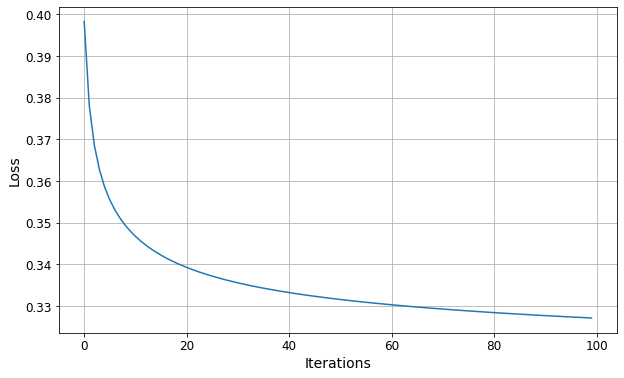

In [ ]:
plt.figure(figsize=(10,6)) 
plt.plot(np.arange(iterations),Loss) 
plt.grid(True) 
plt.xlabel('Iterations') 
plt.ylabel('Loss')
plt.show()

What actually happened behind the screen is that the library automatically created 10 binary classifiers and trained them ! During the interference time, the input will be passed through all the 10 classifiers and the highest score among the outputs will be considered as the predicted class. To see it in acction, let us execute the following lines of code.



In [ ]:
pipe_sgd_ovr[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=1729, warm_start=True)

In [ ]:
pipe_sgd_ovr[1].coef_.shape

(10, 784)

So, it is a matrix of size $ 10 \times 784$. A row represents the weights of a single binary classifier.


In [ ]:
y_hat = pipe_sgd_ovr.predict(x_test) ; y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

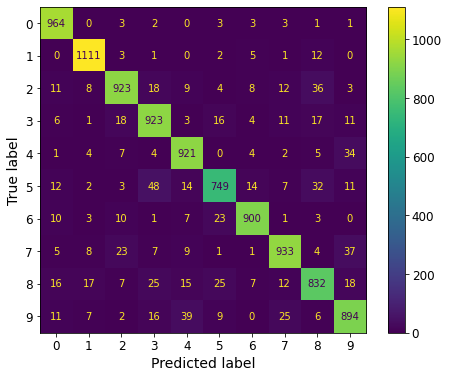

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions( y_test, y_hat, values_format='.5g' )

In [ ]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



## Multi-class LogisticRegression using solvers 

In [ ]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(),LogisticRegression(random_state=1729,
                                                                 solver='lbfgs',
                                                                 C=np.infty)) 
pipe_logit_ovr.fit(x_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

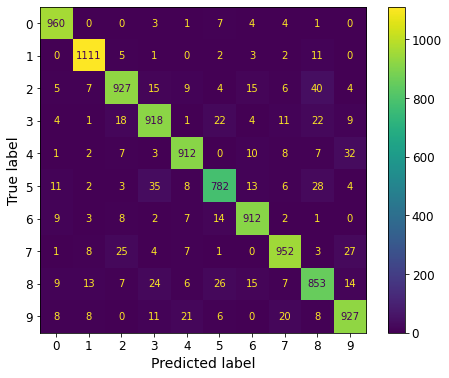

In [ ]:
y_hat = pipe_logit_ovr.predict(x_test) 
cm_display = ConfusionMatrixDisplay.from_predictions(y_test,y_hat, values_format='.5g')

In [ ]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



## Visualize the weight values


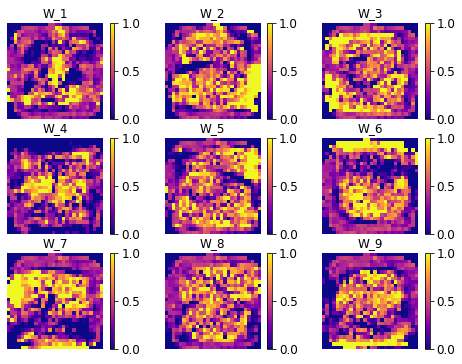

In [ ]:
w = pipe_logit_ovr[1].coef_
# normalize
w =MinMaxScaler().fit_transform(w) 
plt.subplots(3,3)
for i in range(9):
  #w_i[w_i<0]=0
  plt.subplot(3,3,i+1)
  plt.imshow(w[i+1].reshape(28,28), cmap='plasma')
  plt.title('W_{0}'.format(i+1))
  plt.grid(False)
  plt.axis('off')
  plt.colorbar() 

plt.show()

# Text Classification with Naive Bayes classifier 

In this colab, we will use Naive Bayes classifier for classifying text.

Naive Bayes classifier is used for text classification and spam detection tasks.

Here is an example as how to perform the text classification with Naive Bayes classifier.

In [ ]:
#Data loading 
from sklearn.datasets import fetch_20newsgroups 
 
#Preprocessing 
from sklearn.feature_extraction.text import TfidfVectorizer

#Model/estimator 
from sklearn.naive_bayes import MultinomialNB 

#Pipeline utility 
from sklearn.pipeline import make_pipeline 

#Model evaluation 
from sklearn.metrics import ConfusionMatrixDisplay 

#plotting library 
import matplotlib.pyplot as plt


## Exercise read about **TfidfVectorizer** API

#Dataset 

We will be using 20 newsgroup data set for classification 

As a first step, let's download 20 newsgroup dataset with `fetch_20newsgroup`API.



In [ ]:
data = fetch_20newsgroups() 


Let's look at the names of the classes 


In [ ]:
data.target_names

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

There are **20 categories** in the dataset. For simplicity, we will select **4** of these categories and download training and test sets.


In [ ]:
categories = ['talk.religion.misc','soc.religion.christian','sci.space','comp.graphics'] 
train = fetch_20newsgroups(subset='train', categories=categories) 
test = fetch_20newsgroups(subset='test',categories=categories) 

Let's look at a sample trianing document: 


In [ ]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



This data is different than what we have seen so far. Here the training data contains document in text form.


## Data preprocessing and modeling 

As we have mentioned this in the first week of machine learning techniques course, we need to convert the text data to numeric form.
`TfidfVectorizer` is one such API that converts text input into a vector of numerical values.

We will use `TfidfVectorizer` as a preprocessing step to obtain feature vector corresponding to the text document.

We will be using multinomial naive Bayes Classifier for categorizing documents from 20newsgroup corpus. 




In [ ]:
model = make_pipeline(TfidfVectorizer(),MultinomialNB()) 

In [ ]:
model.fit(train.data,train.target)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

## Model evaluation 

Let's first predict the labels for the test set and then calculate the confusion matrix for the test set.


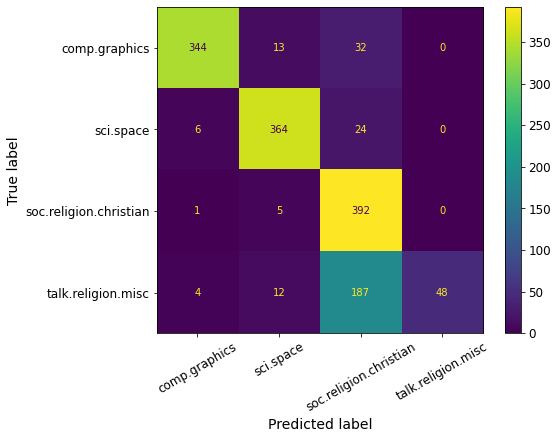

In [ ]:
ConfusionMatrixDisplay.from_estimator(model,test.data, test.target, display_labels=test.target_names,xticks_rotation=30) 
plt.show()

Observe that: 
  * There is a confusion between documents of class `soc.religion.christian` and `talk.religion.misc`, which is along the expected lines.
  * The classes `comp.graphics` and `sci.space` are well separated by such a simple classifier.

Now we have a tool to classify statements into one of these four classes.
  Make use of `predict` function on pipeline for predicting category of a test string.
   

In [ ]:
def predict_category(s, train = train, model=model):
  pred = model.predict([s]) 
  return train.target_names[pred[0]]

Using this function for prediction:

In [ ]:
predict_category('sending a payload to this ISS') 


'sci.space'

In [ ]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [ ]:
predict_category('determining the screen resolution')

'comp.graphics'

(1,)